Text(0, 0.5, 'Progression Progress')

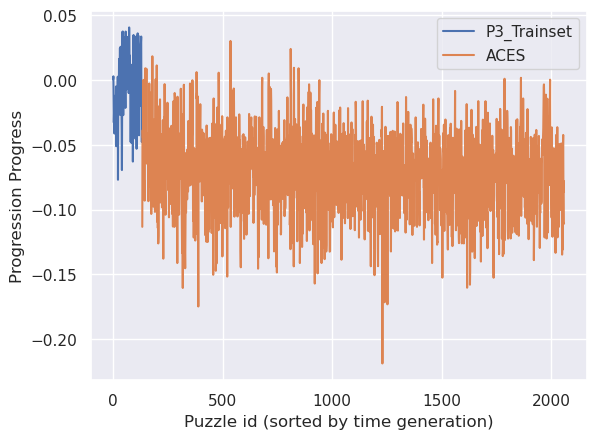

In [88]:
import sys
sys.path.append('/home/flowers/work/OpenELM')
import pickle
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from openelm.environments.p3.p3 import P3ProbSolResult
import json
def pass_at_k(n, c, k):
    """:param n: total number of samples    :param c: number of correct samples     :param k: k in pass@k"""
    assert n >= k
    if n - c < k:
        return 1.0
    return 1.0 - np.prod(1.0 - k / np.arange(n - c + 1, n + 1))


snapshot_path= "/home/flowers/work/OpenELM/logs/elm/24-02-05_15:39/step_130/puzzles.json"
with open(snapshot_path, "r") as f:
    genomes = json.load(f)

list_fitness_train=[]
list_fitness=[]
list_idx_gen=[puz["idx_generation"] for puz in genomes]
for puz in genomes:

    if "fitnessPP" in puz:
        if puz["idx_generation"]==-1:
            list_fitness_train.append(puz["fitnessPP"])
        else:
            list_fitness.append(puz["fitnessPP"])
x_train=np.arange(len(list_fitness_train))
x=np.arange(len(x_train),len(list_fitness)+len(x_train))
plt.plot(x_train,list_fitness_train)
plt.plot(x,list_fitness)
plt.legend(["P3_Trainset","ACES"])
plt.xlabel("Puzzle id (sorted by time generation)")
plt.ylabel("Progression Progress")

# Results of new ACES run
I launched an ACES run (130 generation ~ 2000 puzzles) with the new prompt to look for any problem especially concerning the previous problem in the computational shift from g to f.
First, it seems that the computational shift is no longer present (or rarely).
However, there are other problems. One of them is that sometimes the function f is similar to g. I didn't compute how often it happens but it can be problematic.

The problem is we want f the problem and g such as f(g(args),args) == True for preferably every possible args so the solution g generalizes to every args.
It means that unless the problem is asymmetrical in the sense that the solution (f) is easier (or harder) to find than (g), f should be similar to g. 
For example:
- solving sudoku is an asymmetrical problem, it's easy to verify a solution but harder to find a solution.
- check if factorial is implemented correctly is a symmetrical problem in P3 Framework, see below:

```python
def f(factorial: int, n=5) -> bool:
    def calc_factorial(n):
        if n == 0:
            return 1
        return n * calc_factorial(n - 1)
    
    return factorial == calc_factorial(n)

def g(n=5) -> int:
    def calc_factorial(n):
        if n == 0:
            return 1
        return n * calc_factorial(n - 1)
    return calc_factorial(n)

assert f(g()) == True
```
Note that this problem could be asymmetrical if we could have a variant of the P3 framework that gives the function of g to f (and not its results, so we just verify `assert f(g,args)` or just `assert f(g)`)
In this variant, we could just check the correctness of g with:

```python
def f(factorial):
    try:
        n=5
        assert factorial(n)/factorial(n-1)==n
        assert factorial(0)==1
        return True
    except:
        return False
def g...
assert f(g) == True
```

Besides this, I should also check the trainset because there are puzzles like that in the P3 trainset and I should probably remove them:
```python
Puzzle description: The puzzle involves a function f that takes a string and checks if the string can be transformed into a target string using a specific permutation. The solution function g generates a string that can be transformed into the target string using the inverse permutation. The assertion at the end checks if applying g to f results in True.

def f(s: str, perm='qwertyuiopasdfghjklzxcvbnm', target='mujychenyzo') -> bool:
    return ''.join((perm[(perm.index(c) + 1) % len(perm)] if c in perm else c for c in s)) == target
def g(perm = 'qwertyuiopasdfghjklzxcvbnm', target = 'mujychenyzo'):
    return "".join((perm[(perm.index(c) - 1) % len(perm)] if c in perm else c) for c in target)
assert f(g()) == True
```

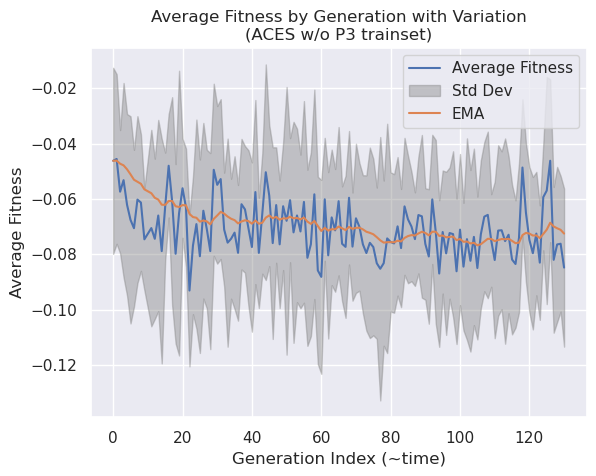

In [105]:
# Assuming list_fitness and list_idx_gen are populated as per your context
list_fitness = []  # This will be populated with fitness values
list_idx_gen = [puz["idx_generation"] for puz in genomes]  # Generation indices

# Placeholder for genomes.archive processing to fill list_fitness
for puz in genomes:
    if "fitnessPP" in puz:
        list_fitness.append(puz["fitnessPP"])

# Map each generation index to its fitness values
fitness_per_generation = defaultdict(list)
for idx, fitness in zip(list_idx_gen, list_fitness):
    fitness_per_generation[idx].append(fitness)

# Calculate the average fitness and standard deviation per generation
avg_fitness_per_gen = {}
std_dev_fitness_per_gen = {}
for gen, fitnesses in fitness_per_generation.items():
    avg_fitness_per_gen[gen] = np.mean(fitnesses)
    std_dev_fitness_per_gen[gen] = np.std(fitnesses)

# Sort the generations to plot them in order
sorted_gen_indices = sorted(avg_fitness_per_gen.keys())
sorted_avg_fitness = [avg_fitness_per_gen[gen] for gen in sorted_gen_indices]
sorted_std_dev_fitness = [std_dev_fitness_per_gen[gen] for gen in sorted_gen_indices]

# Calculate the upper and lower bounds for the fill
upper_bound = [avg + std for avg, std in zip(sorted_avg_fitness, sorted_std_dev_fitness)]
lower_bound = [avg - std for avg, std in zip(sorted_avg_fitness, sorted_std_dev_fitness)]

# Plotting
first_idx=1

plt.plot(sorted_gen_indices[first_idx:], sorted_avg_fitness[first_idx:], label='Average Fitness')
plt.fill_between(sorted_gen_indices[first_idx:], lower_bound[first_idx:], upper_bound[first_idx:], color='gray', alpha=0.4, label='Std Dev')
#plot ema
ema = [sorted_avg_fitness[first_idx]]
alpha = 0.1
for i in range(1, len(sorted_avg_fitness[first_idx:])):
   ema.append(alpha * sorted_avg_fitness[first_idx:][i] + (1 - alpha) * ema[i - 1])
plt.plot(sorted_gen_indices[first_idx:], ema, label='EMA')
plt.xlabel("Generation Index (~time)")
plt.ylabel("Average Fitness")
plt.title("Average Fitness by Generation with Variation\n(ACES w/o P3 trainset)")
plt.legend()
plt.show()


## Progression Progress (c.f. [@Laetitia post](https://openlab-flowers.inria.fr/t/compression-progress-in-p3/2923))

To analyze the ACES archive I tried to compute the PP of each puzzle.

[insert figure above]

There is a relatively slow trend downward, but it is relatively noisy so I don't know if it is really meaningful.

## pass@k
In addition, I also computed the difficulty (pass_k) of each puzzle with [deepseek-coder-1.3b-instruct](https://huggingface.co/deepseek-ai/deepseek-coder-1.3b-instruct) to maybe find any potential correlation. And to look for the evolution of difficulty across time.

[insert figure 1 below]
In this first plot the evolution of the difficulty is stable (see Exponential Moving Average) and it is similar to the difficulty of the trainset.
note: lower is harder pass_1 = 0 -> unsolved, 0.2 -> solved in 1 attempt out of 5, ..., 1. -> solved in 5 attempts out of 5.

The distribution is relatively similar between the P3 trainset and ACES puzzles: 
[insert figure 2 below ]

## Correlation PP and pass@k
Surprisingly, I don't see any correlation between those two... 
 
[insert figure 3 below] 


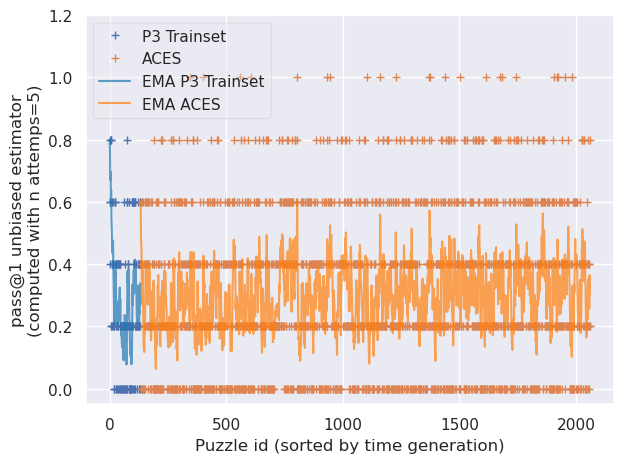

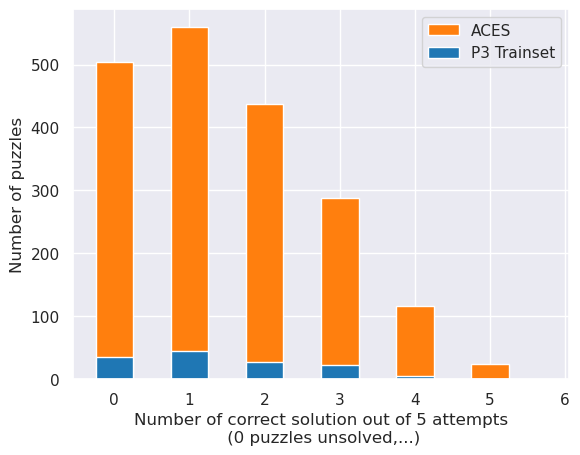

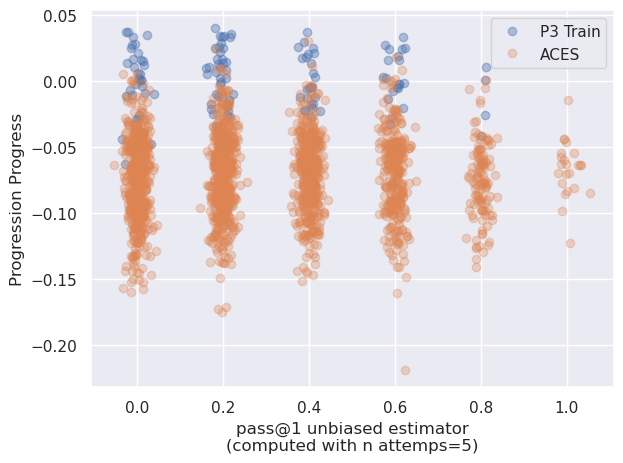

In [162]:
list_fitness=[]
list_passk=[]
list_correct=[]
list_fitness_train=[]
list_passk_train=[]
list_correct_train=[]
n=5
c=1
k=1
for puz in genomes:
    if puz["idx_generation"]!=-1:
        if "fitnessPP" in puz and "n_correct" in puz:
            list_fitness.append(puz["fitnessPP"])
            list_passk.append(pass_at_k(n, puz["n_correct"], k))#puz["n_correct"]/5)   
            list_correct.append(puz["n_correct"])
    else:
        if "fitnessPP" in puz and "n_correct" in puz:
            list_fitness_train.append(puz["fitnessPP"])
            list_passk_train.append(pass_at_k(n, puz["n_correct"], k))
            list_correct_train.append(puz["n_correct"])

#plot pass@k sorted by time
x_train=np.arange(len(list_fitness_train))
x=np.arange(len(x_train),len(list_fitness)+len(x_train))
plt.plot(x_train,list_passk_train,'+',label="P3 Trainset")
plt.plot(x,list_passk,'+',label="ACES")
ema = [list_passk_train[0]]
alpha = 0.2
for i in range(1, len(list_passk_train)):
    ema.append(alpha * list_passk_train[i] + (1 - alpha) * ema[i - 1])
plt.plot(x_train, ema,label="EMA P3 Trainset",color="tab:blue",alpha=0.7)
ema = [list_passk[0]]
for i in range(1, len(list_passk)):
    ema.append(alpha * list_passk[i] + (1 - alpha) * ema[i - 1])
plt.plot(x, ema,label="EMA ACES",color="tab:orange",alpha=0.7)
plt.legend(fancybox=True, framealpha=0.4)
plt.ylim(top=1.2)
plt.xlabel("Puzzle id (sorted by time generation)")
plt.ylabel("pass@1 unbiased estimator\n(computed with n attemps=5)")
plt.tight_layout()
plt.show()

# plot pass@k distribution
bins = np.linspace(0,6, 7)-0.25
plt.hist(list_correct,bins=bins,align="mid",width=0.5,label="ACES",alpha=1,color="tab:orange")
plt.ylabel("Number of puzzles")
plt.xlabel("Number of correct solution out of 5 attempts\n (0 puzzles unsolved,...)")
plt.hist(list_correct_train,bins=bins,align="mid",width=0.5,label="P3 Trainset",alpha=1,color="tab:blue")
plt.ylabel("Number of puzzles")
plt.xlabel("Number of correct solution out of 5 attempts\n (0 puzzles unsolved,...)")
plt.legend()
plt.show()

# plot correlation between pass@k and fitness

list_passk_train=np.array(list_passk_train)
# add small noise to avoid overlap
list_passk_train+=np.random.normal(0, 0.015, len(list_passk_train))
list_passk=np.array(list_passk)
list_passk+=np.random.normal(0, 0.015, len(list_passk))
plt.plot(list_passk_train,list_fitness_train , 'o',alpha=0.4)
plt.plot(list_passk,list_fitness , 'o',alpha=0.3)
plt.legend(["P3 Train", "ACES"])
plt.xlabel("pass@1 unbiased estimator\n(computed with n attemps=5)")
plt.ylabel("Progression Progress")
plt.tight_layout()
plt.show()



In [95]:
for puz in genomes:
    if puz["n_correct"]==1 and puz["idx_generation"]==-1:
        print("\n")
        print(puz["description"][0][0])
        print(puz["program_str"])
        



The puzzle requires the student to write a function that takes a list of integers and returns a boolean value based on a comparison with a given string. The solution function generates a list of integers based on the index of characters in another string.
from typing import List 
def f(li: List[int]) -> bool:
    return ['The quick brown fox jumps over the lazy dog'[i] for i in li] == list('The five boxing wizards jump quickly')
def g():
    return ['The quick brown fox jumps over the lazy dog'.index(t)
            for t in 'The five boxing wizards jump quickly']
assert f(g()) == True


The puzzle requires students to determine if the result of a mathematical operation satisfies a specific condition using string manipulation.
def f(x: float) -> bool:
    return str(x - 3.1415).startswith('123.456')
def g():
    return 123.456 + 3.1415
assert f(g()) == True


The puzzle requires the student to define a function that takes a list of integers and checks if the sum of all possible pairs 

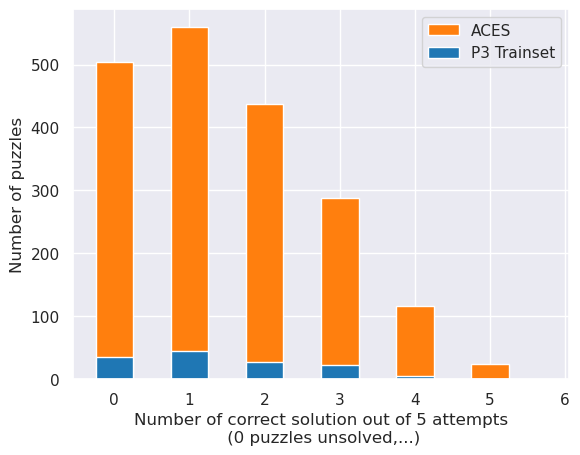

In [54]:
set(list_correct)

{0, 1, 2, 3, 4, 5}

In [77]:
# np.mean(list_passk_train), np.mean(list_passk)
list_k=[i for i in range(1,6)]

print("pass_k train")
pass_k_train={}
for k in list_k:
    pass_k_train[f"pass_{k}"]=[]
for corr in list_correct_train:
    for k in list_k:
        pass_k_train[f"pass_{k}"].append(pass_at_k(n, corr, k))
for k in list_k:
    print(f"pass@{k} = {np.mean(pass_k_train[f'pass_{k}'])}")

print("========\npass_k ACES")
pass_k={}
for k in list_k:
    pass_k[f"pass_{k}"]=[]
for corr in list_correct:
    for k in list_k:
        pass_k[f"pass_{k}"].append(pass_at_k(n, corr, k))
for k in list_k:
    print(f"pass@{k} = {np.mean(pass_k[f'pass_{k}'])}")

pass_k train
pass@1 = 0.2721804511278195
pass@2 = 0.456390977443609
pass@3 = 0.5812030075187969
pass@4 = 0.6691729323308271
pass@5 = 0.7368421052631579
pass_k ACES
pass@1 = 0.29844398340248957
pass@2 = 0.4813796680497926
pass@3 = 0.5997406639004149
pass@4 = 0.6804979253112033
pass@5 = 0.7385892116182573
